# Customer Clustering 

What kind of customers spend the most? What kind of customer groups are there in the business? Any people who spend the most or least? How could we target different customer groups differently per email, ads etc? This code aims to answers those questions. 

In [20]:
import pandas as pd 

df = pd.read_csv('Customers.csv')
df

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...,...
1995,1996,Female,71,184387,40,Artist,8,7
1996,1997,Female,91,73158,32,Doctor,7,7
1997,1998,Male,87,90961,14,Healthcare,9,2
1998,1999,Male,77,182109,4,Executive,7,2


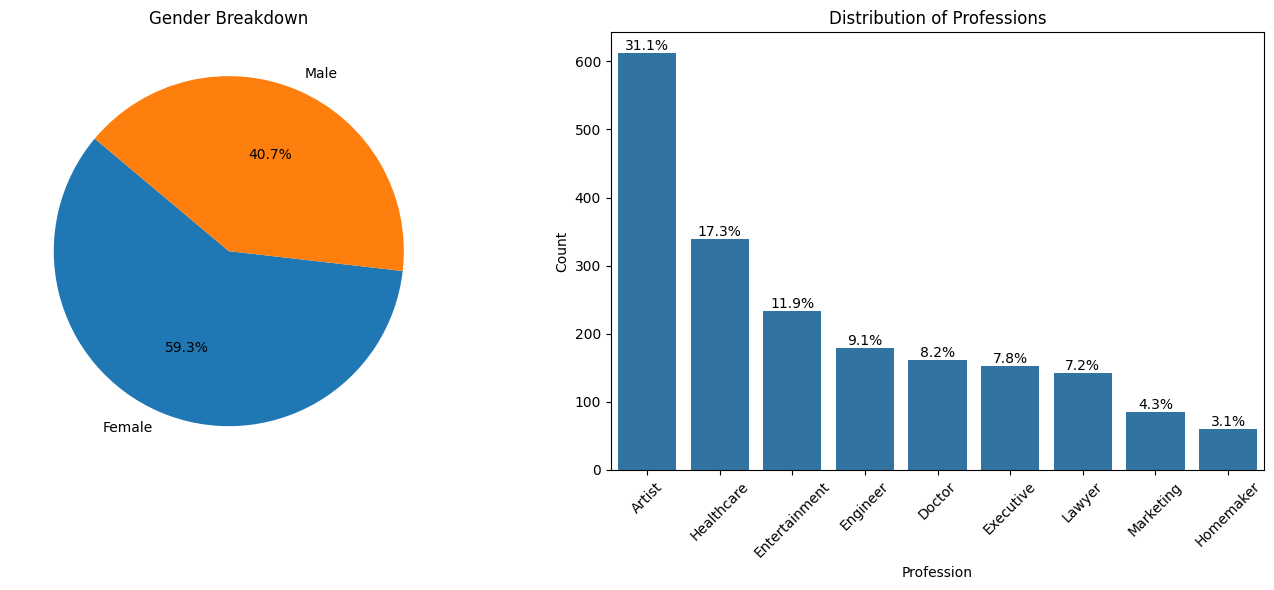

In [23]:
import seaborn as sns 
import matplotlib.pyplot as plt

gender_counts = df['Gender'].value_counts() # First make a count of genders so we can visualize 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot - Gender breakdown
axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Gender Breakdown')

# Second plot - Distribution of Professions
profession_count = df['Profession'].value_counts().reset_index()
profession_count.columns = ['Profession', 'Count']

# Calculate the percentage of total for each profession
total_count = profession_count['Count'].sum()
profession_count['Percentage'] = (profession_count['Count'] / total_count) * 100

ax = sns.barplot(x='Profession', y='Count', data=profession_count, ax=axes[1])
axes[1].set_title('Distribution of Professions')
axes[1].set_xlabel('Profession')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x labels if necessary for better readability

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total_count)
    ax.text(p.get_x() + p.get_width() / 2., height, percentage, ha='center', va='bottom')

plt.tight_layout()
plt.show()

General Statistics of the Annual Income
count      2000.000000
mean     110731.821500
std       45739.536688
min           0.000000
25%       74572.000000
50%      110045.000000
75%      149092.750000
max      189974.000000
Name: Annual Income ($), dtype: float64


Text(0.5, 0, 'Annual Income ($)')

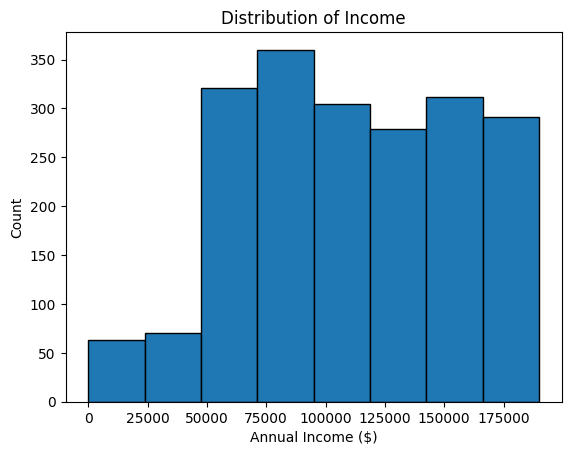

In [32]:
print('General Statistics of the Annual Income')
print(df['Annual Income ($)'].describe())

plt.hist(df['Annual Income ($)'], bins=8, edgecolor = 'black')
plt.title('Distribution of Income')
plt.ylabel('Count')
plt.xlabel('Annual Income ($)')

### Let's do some customer clustering

In [64]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

km = df.copy()

# Creating a LabelEncoder object
label_encoder = LabelEncoder()

# Converting 'profession' column to numerical values
km['Profession'] = label_encoder.fit_transform(km['Profession'])
km['Gender'] = label_encoder.fit_transform(km['Gender'])
km.rename(columns={'Gender':'Is_Male'}, inplace=True)
km = km[['Is_Male', 'Age', 'Annual Income ($)',
       'Spending Score (1-100)', 'Profession', 'Work Experience',
       'Family Size']]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(km)
km

,Is_Male,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,19,15000,39,5,1,4
1,1,21,35000,81,2,3,3
2,0,20,86000,6,2,1,1
3,0,23,59000,77,7,0,2
4,0,31,38000,40,3,2,6
...,...,...,...,...,...,...,...
1995,0,71,184387,40,0,8,7
1996,0,91,73158,32,1,7,7
1997,1,87,90961,14,5,9,2
1998,1,77,182109,4,4,7,2


### Elbow method to see how to best choose number of clusters

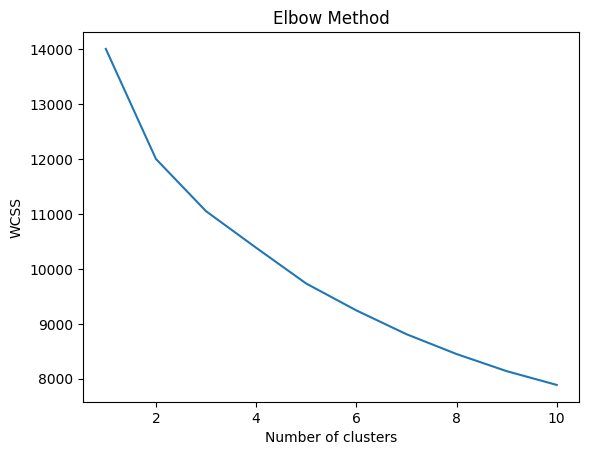

In [57]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [63]:
# Apply K-means with the optimal number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original dataset
km['Cluster'] = clusters

# Analyze the clusters
cluster_analysis = km.groupby('Cluster').mean()

print('This shows group means per cluster')
cluster_analysis

This shows group means per cluster


,Is_Male,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
Cluster,,,,,,,
0,0.089744,47.717949,124670.112821,47.676923,2.717949,9.264103,4.079487
1,1.000000,48.918742,109864.840105,51.234600,2.961992,3.845347,3.744430
2,0.012793,42.609808,77509.208955,51.673774,1.989339,2.149254,2.788913
3,0.026455,58.203704,139321.711640,52.920635,4.296296,1.719577,4.711640
